In [1]:
import numpy as np
import pandas as pd
from avipy import qty, geo
from vinc import v_direct
import math
import time
import matplotlib.pyplot as plt

#### 2. Test v_direct function

In [2]:
boston = geo.Coord(42.3541165, -71.0693514)
newyork = geo.Coord(40.7791472, -73.9680804)

distance1, azimuth1 = v_direct(boston.get_latlon(), newyork.get_latlon())
distance2, azimuth2 = boston.get_distance_bearing(newyork, "haversine")
distance3, azimuth3 = boston.get_distance_bearing(newyork, "vincenty")

print(f"Using `vinc.py`:")
print(f"Distance between Boston and New York: {distance1:.2f} m")
print(f"Initial azimuth between Boston and New York: {azimuth1:.2f} degrees")

print(f"\nUsing AviPy - Haversine:")
print(f"Distance between Boston and New York: {distance2} m")
print(f"Initial azimuth between Boston and New York: {azimuth2:2f} degrees")

print(f"\nUsing AviPy - Vincenty:")
print(f"Distance between Boston and New York: {distance3} m")
print(f"Initial azimuth between Boston and New York: {azimuth3:.2f} degrees")

Using `vinc.py`:
Distance between Boston and New York: 298396.06 m
Initial azimuth between Boston and New York: 235.08 degrees

Using AviPy - Haversine:
Distance between Boston and New York: 298342.83 meters m
Initial azimuth between Boston and New York: 234.981396 degrees

Using AviPy - Vincenty:
Distance between Boston and New York: 298396.06 meters m
Initial azimuth between Boston and New York: 235.08 degrees


Observations:
- The method in `vinc.py` is accurate, but cumbersome to use.
- The Haversine equation in the AviPy library is less accurate, as its calculations are based on a sphere.
- The Vincenty equation in the AviPy libary provides a "wrapper" for the equations in `vinc.py`. This makes it easy to use, and accurate. One thing to note: the Vincenty equation uses iteration for the computation of the output. This makes it slower than the Haversine equation, which runs in constant time.

#### 3. Find coordinates of AMS, LAX, NRT

In [3]:
AMS = geo.Coord(52.309041, 4.761799)
LAX = geo.Coord(33.944582, -118.408955)
NRT = geo.Coord(35.769395, 140.384192)

#### 4. Find distances between AMS-LAX, AMS-NRT, LAX-NRT in meters, kilometers and nautical miles.

In addition, I want to test the extra time it takes to run the Vincenty equation instead of the Haversine equation. Haversine is slower in theory, but does that difference really matter?

First, using the Haversine equation:

In [4]:
start = time.time()
dist_ams_lax, azimuth_ams_lax = AMS.get_distance_bearing(LAX)
dist_ams_nrt, azimuth_ams_nrt = AMS.get_distance_bearing(NRT)
dist_lax_nrt, azimuth_lax_nrt = LAX.get_distance_bearing(NRT)
print(time.time() - start)

0.000186920166015625


Alright, that's pretty quick. Aproximately 0.1 ms. Let's see how the Vincenty equation performs.

In [5]:
start = time.time()
dist_ams_lax, azimuth_ams_lax = AMS.get_distance_bearing(LAX, "vincenty")
dist_ams_nrt, azimuth_ams_nrt = AMS.get_distance_bearing(NRT, "vincenty")
dist_lax_nrt, azimuth_lax_nrt = LAX.get_distance_bearing(NRT, "vincenty")
print(time.time() - start)

0.00025463104248046875


Okay, not as good but still very acceptable, this is approximately 0.2 ms, double the time of the haversine equation. 

Still, considering the gained precision and the sheer amount of computational power in modern computers, I think it's a no-brainer to use the Vincenty equation.

Now let's have a look at the results from the function.

In [6]:
print(f"AMS - LAX")
print(f"{dist_ams_lax}, {dist_ams_lax.km:.2f} km, {dist_ams_lax.n_mile:.2f} NM")
print(f"Initial Azimuth: {azimuth_ams_lax:.2f} degrees\n")

print(f"AMS - NRT")
print(f"{dist_ams_nrt}, {dist_ams_nrt.km:.2f} km, {dist_ams_nrt.n_mile:.2f} NM")
print(f"Initial Azimuth: {azimuth_ams_nrt:.2f} degrees\n")

print(f"LAX - NRT")
print(f"{dist_lax_nrt}, {dist_lax_nrt.km:.2f} km, {dist_lax_nrt.n_mile:.2f} NM")
print(f"Initial Azimuth: {azimuth_lax_nrt:.2f} degrees\n")

AMS - LAX
8977181.11 meters, 8977.18 km, 4847.29 NM
Initial Azimuth: 315.30 degrees

AMS - NRT
9341468.26 meters, 9341.47 km, 5043.99 NM
Initial Azimuth: 34.77 degrees

LAX - NRT
8772395.35 meters, 8772.40 km, 4736.71 NM
Initial Azimuth: 305.77 degrees



In [7]:
coordinates = {
    "name": [],
    "lat": [],
    "lon": [],
}

coordinates['name'].extend(["AMS", "LAX", "NRT"])
coordinates['lat'].extend([AMS.get_lat(), LAX.get_lat(), NRT.get_lat()])
coordinates['lon'].extend([AMS.get_lon(), LAX.get_lon(), NRT.get_lon()])

df = pd.DataFrame(coordinates)

#### 5. Plot the waypoints in a scatter plot

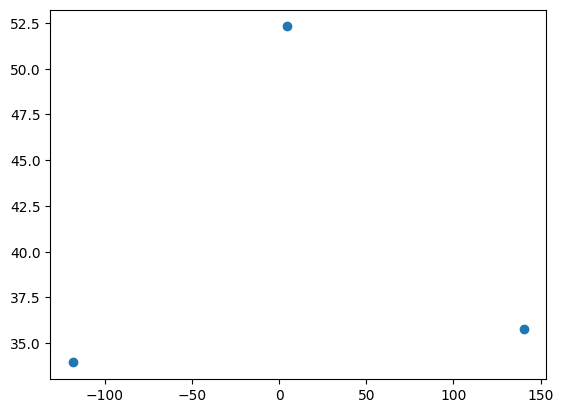

In [8]:
plt.scatter(df['lon'], df['lat'])

#### 6. Find the coordinates 200 km north, north-east, ... etc. around Schiphol and plot them.

In [9]:
distance = qty.Distance.N_mile(200)

for direction in [0, 45, 90, 135, 180, 225, 270, 315]:
    new_coord = AMS.get_next_coord(distance, direction, "vincenty")

    coordinates['name'].append(f"AMS-{direction}")
    coordinates['lat'].append(new_coord.get_lat())
    coordinates['lon'].append(new_coord.get_lon())

df = pd.DataFrame(coordinates)

In [10]:
df

,name,lat,lon
0,AMS,52.309041,4.761799
1,LAX,33.944582,-118.408955
2,NRT,35.769395,140.384192
3,AMS-0,55.636852,4.761799
4,AMS-45,54.595789,8.815031
5,AMS-90,52.184413,10.182416
6,AMS-135,49.896130,8.407476
7,AMS-180,48.979345,4.761799
8,AMS-225,49.896130,1.116122
9,AMS-270,52.184413,-0.658818


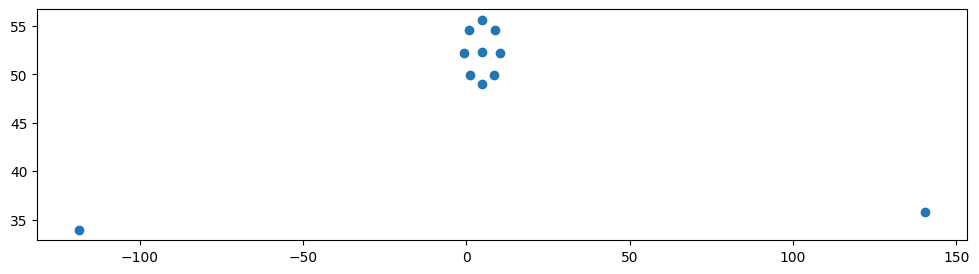

In [11]:
fig = plt.figure(figsize=(12, 3))
plt.scatter(df['lon'], df['lat'], )
ax = plt.gca()


#### 7 .- Assign random distance values to trajectories 1 to three and use an embedded IF statement to find the longest one. Try different combinations to test your logic.

Yeah we can do that:

In [12]:
traj1 = 1500
traj2 = 1830
traj3 = 1000

if traj1 > traj2 and traj1 > traj3:
    print(traj1)
elif traj2 > traj1 and traj2 > traj3:
    print(traj2)
else:
    print(traj3)


1830


Or we can just:

In [13]:
print(max(traj1, traj2, traj3))

1830


Or better:

In [14]:
trajectories = {
    "1": traj1,
    "2": traj2,
    "3": traj3,
}

longest = max(trajectories, key=lambda traj: trajectories[traj])
print(longest)

2


#### 8. Get the longest distance from exercise 4

In [15]:
distances = {
    "AMSLAX": dist_ams_lax,
    "AMSNRT": dist_ams_nrt,
    "LAXNRT": dist_lax_nrt,
}

longest = max(distances, key=lambda distance: distances[distance])

print(f"The longest trajectory is '{longest}', with a distance of {distances[longest].n_mile:.2f} NM")

The longest trajectory is 'AMSNRT', with a distance of 5043.99 NM
